In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score
from sklearn.metrics import plot_precision_recall_curve, recall_score
from sklearn.pipeline import Pipeline
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('max_rows',50000)
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from sklearn.naive_bayes import GaussianNB
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

[nltk_data] Downloading package stopwords to /Users/niall/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/niall/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def get_data():
    input_file = './Sarcasm_Headlines_Dataset.json'
    data = list(parseJson(input_file))

    df = pd.DataFrame(data)
    df = df[['is_sarcastic','headline']]
    df = shuffle(df)
    
    df['headline'] = df.headline.apply(to_lower)
    df['headline'] = df.headline.apply(punctuation_stp_words_lemmatize)
    tfidf_vectorizer = TfidfVectorizer(analyzer ='word', encoding= 'utf-8', decode_error = 'ignore', strip_accents='ascii')
    X = tfidf_vectorizer.fit_transform(df['headline'])
    X = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())
    y = df['is_sarcastic']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    return X_train, X_test, y_train, y_test

In [3]:
table = str.maketrans('', '', string.punctuation)
lemmatizer = WordNetLemmatizer() 
def parseJson(fname):
    for line in open(fname, 'r'):
        yield eval(line)

def to_lower(inp):
    return inp.lower()

def punctuation_lemmatize(inp):
    words = inp.split()
    stripped = [w.translate(table) for w in words]
    stripped = [w for w in stripped if len(w) > 1]
    stripped = [ lemmatizer.lemmatize(w) for w in stripped]    
    return ' '.join(stripped)

def punctuation_stp_words_lemmatize(inp):
    words = inp.split()
    stripped = [w.translate(table) for w in words]
    stripped = [w for w in stripped if len(w) > 1]
    stripped = [w for w in stripped if not w in stop_words]
    stripped = [ lemmatizer.lemmatize(w) for w in stripped]    
    return ' '.join(stripped)

def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer(min_df = 2,max_df = 1.0).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def roc_curve_plot(nb_probs):
    fpr, tpr, _ = roc_curve(y_test, nb_probs)
    plt.plot(fpr, tpr, marker='.', label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
def print_auc_score(nb_probs):
    auc = roc_auc_score(y_test, nb_probs)
    print('AUC: ', auc)
    
def model_analysis(model, model_name, preds, nb_probs):
    average_precision = average_precision_score(y_test, preds)
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))
    print(model_name , ' accuracy score: ' , accuracy_score(y_test, preds))
    print(model_name , ' precision score: ' , precision_score(y_test, preds))
    print(model_name , ' recall score: ' , recall_score(y_test, preds))
    print(model_name , ' average precision-recall score: ' , average_precision)
    
    disp = plot_precision_recall_curve(model, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [4]:
sarcasm_headline_data = get_data()

In [5]:
X_train = sarcasm_headline_data[0]
X_test = sarcasm_headline_data[1]
y_train = sarcasm_headline_data[2]
y_test = sarcasm_headline_data[3]

In [6]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(21464, 25860) (21464,)
(7155, 25860) (7155,)


In [7]:
print("Train Data Distribution ")
print(y_train.value_counts(normalize=True))
print("Test Data Distribution ")
print(y_test.value_counts(normalize=True))

Train Data Distribution 
0    0.521385
1    0.478615
Name: is_sarcastic, dtype: float64
Test Data Distribution 
0    0.530259
1    0.469741
Name: is_sarcastic, dtype: float64


In [8]:
LR_model = pickle.load( open( "./Models/LR_model.pkl", "rb"))
KNN_model = pickle.load( open( "./Models/KNN_model.pkl", "rb"))
GNB_model = pickle.load( open( "./Models/GNB_model.pkl", "rb"))
NB_model = pickle.load( open( "./Models/NB_model.pkl", "rb" ))
SVM_model = pickle.load( open( "./Models/SVM_model.pkl", "rb"))

In [9]:
KNN_model.fit(X_train, y_train)
print('finsih')
GNB_model.fit(X_train, y_train)
print('finsih')
NB_model.fit(X_train, y_train)
print('finsih')

finsih
finsih
finsih


In [10]:
GNB_predictions = GNB_model.predict(X_test)
print('finsih')
NB_predictions = NB_model.predict(X_test)
print('finsih')

finsih
finsih


In [11]:
GNB_nb_probs = GNB_model.predict_proba(X_test)
GNB_nb_probs = GNB_nb_probs[:, 1]

NB_nb_probs = NB_model.predict_proba(X_test)
NB_nb_probs = NB_nb_probs[:, 1]

In [12]:
print('GNB accuracy score' , accuracy_score(y_test, GNB_predictions))
print('NB accuracy score' , accuracy_score(y_test, NB_predictions))

GNB accuracy score 0.6550663871418588
NB accuracy score 0.7966457023060797


              precision    recall  f1-score   support

           0       0.63      0.83      0.72      3794
           1       0.71      0.45      0.55      3361

    accuracy                           0.66      7155
   macro avg       0.67      0.64      0.64      7155
weighted avg       0.67      0.66      0.64      7155

[[3166  628]
 [1840 1521]]
GNB   accuracy score:  0.6550663871418588
GNB   precision score:  0.7077710563052583
GNB   recall score:  0.4525438857482892
GNB   average precision-recall score:  0.5774602872411119


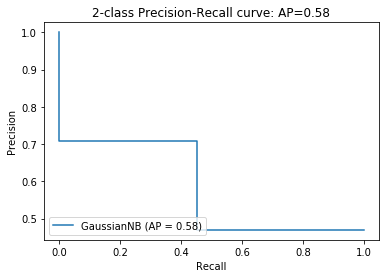

In [13]:
model_analysis(GNB_model, 'GNB ', GNB_predictions, GNB_nb_probs)

AUC:  0.6436858209700811


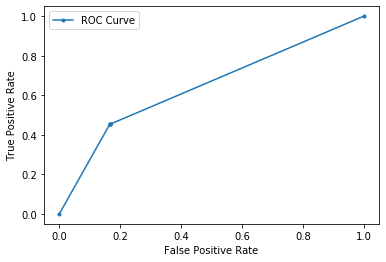

In [14]:
print_auc_score(GNB_nb_probs)
roc_curve_plot(GNB_nb_probs)

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3794
           1       0.81      0.74      0.77      3361

    accuracy                           0.80      7155
   macro avg       0.80      0.79      0.79      7155
weighted avg       0.80      0.80      0.80      7155

[[3226  568]
 [ 887 2474]]
NB   accuracy score:  0.7966457023060797
NB   precision score:  0.8132807363576594
NB   recall score:  0.7360904492710503
NB   average precision-recall score:  0.7226174348801392


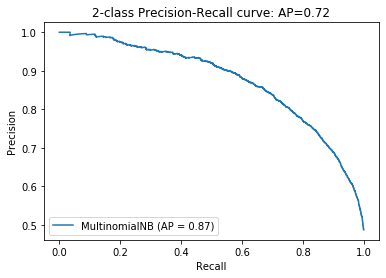

In [15]:
model_analysis(NB_model, 'NB ', NB_predictions, NB_nb_probs)

AUC:  0.8812989770565876


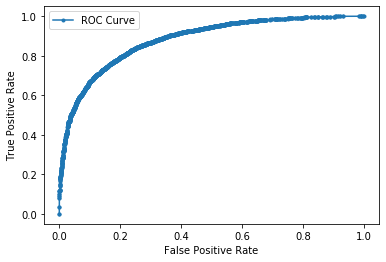

In [16]:
print_auc_score(NB_nb_probs)
roc_curve_plot(NB_nb_probs)